# 1. Import libraries

In [1]:
pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import string
import math
from collections import Counter
from Levenshtein import distance as levenshtein_distance
import tensorflow as tf
# ✅ Set memory growth before any other TF operations
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)  # Enable memory growth
        print("GPU memory growth set.")
    except RuntimeError as e:
        print(e)  # Prints error if TensorFlow is already initialized
else:
    print("No GPU found!")
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

GPU memory growth set.


# 2. Load the data

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/passwordstrengthdataset/pwlds_full.csv
/kaggle/input/passwordstrengthdataset/LICENSE
/kaggle/input/passwordstrengthdataset/pwlds_very_weak.csv
/kaggle/input/passwordstrengthdataset/README.md
/kaggle/input/passwordstrengthdataset/pwlds_average.csv
/kaggle/input/passwordstrengthdataset/pwlds_strong.csv
/kaggle/input/passwordstrengthdataset/pwlds_very_strong.csv
/kaggle/input/passwordstrengthdataset/pwlds_weak.csv
/kaggle/input/common-pwd/top1million-vn-passwords.txt
/kaggle/input/common-pwd/top1k-vn-passwords.txt
/kaggle/input/common-pwd/top10k-vn-passwords.txt


In [4]:
data_path = "/kaggle/input/passwordstrengthdataset/pwlds_full.csv"

df = pd.read_csv(data_path).dropna()
print(df[:10])

  Password  Strength_Level
0    7hqwv               0
1     cjml               0
2     asuy               0
3    kcyth               0
4     whcq               0
5     iome               0
6     eggp               0
7    wtdvn               0
8     kspx               0
9      yys               0


# 3. Data processing

## 3.1 Extract Shannon Entropy

In [5]:
# Shannon Entropy Calculation
def shannon_entropy(password):
    if not password:
        return 0
    freq = Counter(password)
    length = len(password)
    return -sum((count / length) * math.log2(count / length) for count in freq.values())


## 3.2 Extract Character Diversity Score

In [6]:
# Character Diversity Score
def char_diversity_score(password):
    return len(set(password)) / len(password) if password else 0

## 3.3 Extract Longest Consecutive Repeating Character Sequence

In [7]:
# Longest Consecutive Repeating Character Sequence
def longest_repeating_sequence(password):
    max_count, count = 1, 1
    for i in range(1, len(password)):
        if password[i] == password[i - 1]:
            count += 1
        else:
            count = 1
        max_count = max(max_count, count)
    return max_count

## 3.4 Extract Longest Consecutive Numeric Sequence

In [8]:
# Longest Consecutive Numeric Sequence
def longest_numeric_sequence(password):
    max_count, count = 0, 0
    for char in password:
        if char.isdigit():
            count += 1
            max_count = max(max_count, count)
        else:
            count = 0
    return max_count

## 3.5 Extract Longest Consecutive Letter Sequence

In [9]:
# Longest Consecutive Letter Sequence
def longest_letter_sequence(password):
    max_count, count = 0, 0
    for char in password:
        if char.isalpha():
            count += 1
            max_count = max(max_count, count)
        else:
            count = 0
    return max_count

## 3.6 Common passowrd

In [10]:
# Define common password
def load_common_passwords(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        common_passwords = set(line.strip() for line in f if line.strip())  # Remove empty lines
    return common_passwords

file_path = "/kaggle/input/common-pwd/top1k-vn-passwords.txt" 
common_passwords = load_common_passwords(file_path)

# Print Sample Data
print(f"Loaded {len(common_passwords)} common passwords.")
print(list(common_passwords)[:10])  # Show first 10 passwords


# Check if the password contains a common password
def contains_common_password(password):
    return int(password.lower() in common_passwords)

# Check if the reversed password contains a common password
def contains_reversed_password(password):
    return int(password.lower()[::-1] in common_passwords)
    
# Compute Levenshtein distance to common passwords
def min_levenshtein_distance(password):
    return min([levenshtein_distance(password, common) for common in common_passwords])

Loaded 1000 common passwords.
['1122334455', '23456789', 'thanhthuy', 'chochet', '01233210', 'quanghuy', '963852741', '456789', 'hoilamgi', '1475369']


## Extract all the entropy

In [11]:
# Feature extraction function
def extract_features(df):
    print("Starting Feature Extraction...")

    df['password_length'] = df['Password'].apply(len)
    print("Extracted: Password Length")

    df['num_uppercase'] = df['Password'].apply(lambda x: sum(1 for c in x if c.isupper()))
    print("Extracted: Number of Uppercase Letters")

    df['num_lowercase'] = df['Password'].apply(lambda x: sum(1 for c in x if c.islower()))
    print("Extracted: Number of Lowercase Letters")

    df['num_digits'] = df['Password'].apply(lambda x: sum(1 for c in x if c.isdigit()))
    print("Extracted: Number of Digits")

    df['num_special_chars'] = df['Password'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
    print("Extracted: Number of Special Characters")

    df['shannon_entropy'] = df['Password'].apply(shannon_entropy)
    print("Extracted: Shannon Entropy")

    df['char_diversity_score'] = df['Password'].apply(char_diversity_score)
    print("Extracted: Character Diversity Score")

    df['longest_repeating_seq'] = df['Password'].apply(longest_repeating_sequence)
    print("Extracted: Longest Repeating Sequence")

    df['longest_numeric_seq'] = df['Password'].apply(longest_numeric_sequence)
    print("Extracted: Longest Numeric Sequence")

    df['longest_letter_seq'] = df['Password'].apply(longest_letter_sequence)
    print("Extracted: Longest Letter Sequence")
    
    df['contains_common_password'] = df['Password'].apply(contains_common_password)
    print("Extracted: Contains Common Password")

    df['contains_reversed_password'] = df['Password'].apply(contains_reversed_password)
    print("Extracted: Contains Reversed Password")
    print("Feature Extraction Completed!")
    return df


# Apply feature extraction
df = extract_features(df)

# Drop original password column
df.drop(columns=['Password'], inplace=True)

# Save processed data
df.to_csv("processed_password_data.csv", index=False)

print(df.head())

Starting Feature Extraction...
Extracted: Password Length
Extracted: Number of Uppercase Letters
Extracted: Number of Lowercase Letters
Extracted: Number of Digits
Extracted: Number of Special Characters
Extracted: Shannon Entropy
Extracted: Character Diversity Score
Extracted: Longest Repeating Sequence
Extracted: Longest Numeric Sequence
Extracted: Longest Letter Sequence
Extracted: Contains Common Password
Extracted: Contains Reversed Password
Feature Extraction Completed!
   Strength_Level  password_length  num_uppercase  num_lowercase  num_digits  \
0               0                5              0              4           1   
1               0                4              0              4           0   
2               0                4              0              4           0   
3               0                5              0              5           0   
4               0                4              0              4           0   

   num_special_chars  shannon_entropy 

In [17]:
# Check If a GPU is Available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 2


# 4. Split data

In [18]:
# Load Preprocessed Data
data_path = "/kaggle/working/processed_password_data.csv"
df = pd.read_csv(data_path)

In [19]:
# Separate features (X) and target (y)
X = df.drop('Strength_Level', axis=1)
y = df['Strength_Level']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Train the model

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [21]:
# Determine the number of classes
num_classes = y.nunique()

# Initialize the model
model = XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    random_state=42,
    use_label_encoder=False,  # Avoids warning
    eval_metric='mlogloss'     # Multiclass log loss
)

# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

# 6. Evaluate the result

In [24]:
from sklearn.metrics import confusion_matrix
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate performance
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    200003
           1       0.95      0.95      0.95    200001
           2       0.92      0.95      0.94    200001
           3       0.94      0.91      0.93    200014
           4       1.00      1.00      1.00    200000

    accuracy                           0.96   1000019
   macro avg       0.96      0.96      0.96   1000019
weighted avg       0.96      0.96      0.96   1000019


Confusion Matrix:
[[199867    126     10      0      0]
 [   571 189437   3590   6403      0]
 [     0   5287 190346   4368      0]
 [     0   5153  12978 181883      0]
 [     0      0      0      0 200000]]


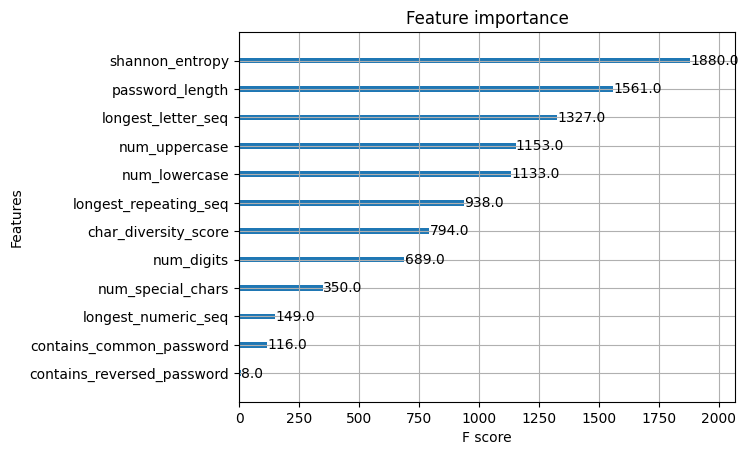

In [23]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model)
plt.show()

# 7. Save the model

In [28]:
import pickle

# Save the model with pickle
with open('/kaggle/working/xgboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)
    